## This is for the exam project


In [1]:
##Imports
from time import sleep
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from bs4 import BeautifulSoup as soup
import bs4
import requests
import re
import sys
import numpy as np

### Numberplate to string

Nummerpladen er: CM58 541



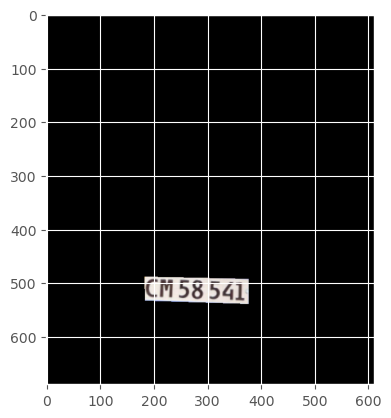

In [202]:
import cv2
import imutils
import numpy as np
from matplotlib import pyplot as plt
import pytesseract

#Windows
#pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

#M1
pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/Cellar/tesseract/4.1.1/bin/tesseract'

#Import image and resize it
#Aygo
img = cv2.imread('./images/aygo.png', cv2.IMREAD_COLOR)
img = imutils.resize(img, width=610)

#Tesla
#img = cv2.imread('./images/tesla.jpg', cv2.IMREAD_COLOR)
#img = imutils.resize(img, width=600)

#Gray scale 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Blur to reduce noise
gray = cv2.bilateralFilter(gray, 13, 15, 15)

#Edge detection
edged = cv2.Canny(gray, 30, 200)

contours = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
screenCnt = None

#Find contours in the edged image
(cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30]

NumberPlateCnt = None 
count = 0
#Loop over contours
for c in cnts:
	#Approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    #If the approximated contour has four points, then assume that screen is found
    if len(approx) == 4:  
        NumberPlateCnt = approx 
        break

#Mask the part other than the numberplate
mask = np.zeros(gray.shape,np.uint8)
new_image = cv2.drawContours(mask,[NumberPlateCnt],0,255,-1)
new_image = cv2.bitwise_and(img,img,mask=mask)

#Crop the image 
(x, y) = np.where(mask == 255)
(topx, topy) = (np.min(x), np.min(y))
(bottomx, bottomy) = (np.max(x), np.max(y))
Cropped = gray[topx:bottomx+1, topy:bottomy+1]

#Read the number plate
config = ('-l eng --oem 1 --psm 3')
text = pytesseract.image_to_string(Cropped, config=config)
print("Nummerpladen er:",text)
plt.imshow(new_image)

cv2.waitKey(1)
cv2.destroyAllWindows() 

### Entering numberplate on nummerplade.net to find model

In [203]:
print("Starting up..")
profile = webdriver.FirefoxProfile()
profile.set_preference("general.useragent.override", "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:81.0) Gecko/20100101 Firefox/81.0")
options = Options()
options.headless = True

#M1
browser = webdriver.Chrome(executable_path="/Users/frederikdahl/chromedriver/chromedriver")

#Windows
#browser = webdriver.Firefox(options=options)

browser.get("https://www.nummerplade.net/")

print("Got Browser")

browser.implicitly_wait(3)

#cookie_button = browser.find_element_by_css_selector('div.coi-banner__page-footer:nth-child(2) > button:nth-child(2)')
#cookie_button.click()
#print("Cookie Button Clicked..")
#sleep(3) 

search_field = browser.find_element_by_id('search_regnr')

search_field.send_keys(text)
#search_field.send_keys("CM 58 541")

button = browser.find_element_by_id('search_regnr_button')
button.click()
print("Search Entered")
sleep(3)

print()

page_source = browser.page_source
page_soup = soup(page_source,'html.parser')
res = page_soup.select_one("#maerke").text +" "+ page_soup.select_one("#model").text + " "

page_source = browser.page_source
page_soup = soup(page_source,'html.parser')
search_car_year = page_soup.select_one("#model_aar").text +" " 
search_car_km = page_soup.select_one("#box-overblik-data-overblik_kmcheck > div > small").text + " "


filter_search_km = re.sub("[^0-9]+", "",search_car_km)
search_car_km = filter_search_km


print("Search_car_km: " + search_car_km)
print("Search_car_year: " + search_car_year)
print("Mærke/model på søgte bil: ", res)
browser.quit()

Starting up..
Got Browser
Search Entered

Search_car_km: 93000
Search_car_year: 2015 
Mærke/model på søgte bil:  Toyota Aygo 


### Searching for model on bilbasen to get model,price,km, 

In [204]:
base_url = 'https://www.bilbasen.dk/'

class my_car:
    def __init__(self, url):
        self.base_url = url
        self.car_list = []
        
        print("Starting up...")
        
        profile = webdriver.FirefoxProfile()
        profile.set_preference("general.useragent.override", "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:81.0) Gecko/20100101 Firefox/81.0")
        options = Options()
        options.headless = True
        
        #Windows
        #self.browser = webdriver.Firefox(options=options)
        
        #M1 
        self.browser  = webdriver.Chrome(executable_path="/Users/frederikdahl/chromedriver/chromedriver")
        
        self.browser.get(self.base_url)
        print("Got Browser")
        
        self.browser.implicitly_wait(3)
        
    def click_cookie_button(self):
        try:
            cookie_button = self.browser.find_element_by_id('onetrust-accept-btn-handler')
            try:
                cookie_button.click()
                print("Cookie Button Clicked")
                sleep(3)   
            except Exception as err:
                print('Error With Cookie Button:', err)
        except Exception as err:
            print(err)
            
    def click_leasing_button(self):
        try:
            leasing_button = self.browser.find_element_by_css_selector("label[data-track-action='leasing-toggle']")
            try:
                leasing_button.click()
                print("Leasing Button Clicked")
                sleep(3)   
            except Exception as err:
                print('Error With Leasing Button:', err)
        except Exception as err:
            print(err)
        
    def search_in_search_bar(self, search_text):
        try:
            search_field = self.browser.find_element_by_class_name('react-autosuggest__input')
            search_field.send_keys(search_text)
            search_field.submit()
            print("Search Bar Entered")
            sleep(3)

        except Exception as err:
            print('Error with Search', err)

    def get_car_list(self):
        print("Souping Site")
        print()
        page_source = self.browser.page_source
        page_soup = soup(page_source,'html.parser')
        car_list_plus = page_soup.findAll("div",{"class":"row listing listing-plus bb-listing-clickable"})
        car_list_discount = page_soup.findAll("div",{"class":"row listing listing-discount bb-listing-clickable"})
        full_list = car_list_plus + car_list_discount
        print("Cars found: " + str(len(full_list)))
        for car in full_list:
            name = car.find("a",{"class":"listing-heading darkLink"}).contents[0]
            km = int(car.findAll("div",{"class":"col-xs-2 listing-data"})[1].contents[0].replace('.',''))
            price = car.find("div",{"class":"col-xs-3 listing-price"}).contents[0].replace(' kr.','').replace('.','')
            year = int(car.findAll("div",{"class":"col-xs-2 listing-data"})[2].contents[0])
            car_info = {"name": name, "km": km, "price": price, "year": year}
            self.car_list.append(car_info)
            print(car_info) 
            
    def close_browser(self):
        self.browser.close()
    
bilbasen = my_car(base_url)
bilbasen.click_cookie_button()
bilbasen.click_leasing_button()
bilbasen.search_in_search_bar(res)
print("Searching for: " + res)
bilbasen.get_car_list()
bilbasen.close_browser()
make_me_dataframe = bilbasen.car_list

Starting up...
Got Browser
Cookie Button Clicked
Leasing Button Clicked
Search Bar Entered
Searching for: Toyota Aygo 
Souping Site

Cars found: 31
{'name': 'Toyota Aygo 1,0 VVT-i x-wave Sky 5d', 'km': 86000, 'price': '64800', 'year': 2015}
{'name': 'Toyota Aygo 1,0 VVT-i x-pression 5d', 'km': 133000, 'price': '59900', 'year': 2016}
{'name': 'Toyota Aygo 1,0 VVT-i x-sky 5d', 'km': 53000, 'price': '74900', 'year': 2015}
{'name': 'Toyota Aygo 1,0 VVT-i x-play 5d', 'km': 99000, 'price': '64900', 'year': 2015}
{'name': 'Toyota Aygo 1,0 VVT-i x-touch 5d', 'km': 99000, 'price': '59800', 'year': 2014}
{'name': 'Toyota Aygo 1,0 VVT-i x-play 5d', 'km': 68000, 'price': '69900', 'year': 2016}
{'name': 'Toyota Aygo 1,0 VVT-i x-play Touch 5d', 'km': 89000, 'price': '73800', 'year': 2015}
{'name': 'Toyota Aygo 1,0 VVT-i x-clusiv 5d', 'km': 28000, 'price': '99900', 'year': 2019}
{'name': 'Toyota Aygo 1,0 VVT-i x-cite 5d', 'km': 40000, 'price': '79500', 'year': 2015}
{'name': 'Toyota Aygo 1,0 Plus 5d'

### Creating dataframe from car list

In [205]:
import pandas as pd
data = pd.DataFrame(make_me_dataframe) 
data.head()

,name,km,price,year
0,"Toyota Aygo 1,0 VVT-i x-wave Sky 5d",86000,64800,2015
1,"Toyota Aygo 1,0 VVT-i x-pression 5d",133000,59900,2016
2,"Toyota Aygo 1,0 VVT-i x-sky 5d",53000,74900,2015
3,"Toyota Aygo 1,0 VVT-i x-play 5d",99000,64900,2015
4,"Toyota Aygo 1,0 VVT-i x-touch 5d",99000,59800,2014


### Normalizing data

In [206]:
from sklearn import preprocessing
import sklearn.linear_model

#Defining features
features = data[['km', 'year', 'price']]

#Normalize data (reduce values to be between 0 and 1)
scaler = preprocessing.MinMaxScaler()
names = features.columns
d = scaler.fit_transform(features)
scaled_df = pd.DataFrame(d, columns=names)
scaled_df.head()




,km,year,price
0,0.372071,0.615385,0.450461
1,0.592315,0.692308,0.394009
2,0.217432,0.615385,0.566820
3,0.432990,0.615385,0.451613
4,0.432990,0.538462,0.392857


### Describing data

In [207]:
# Describing the data 
data.describe()

,km,year
count,31.000000,31.000000
mean,87661.290323,2015.225806
std,57043.145527,3.148647
min,6600.000000,2007.000000
25%,42500.000000,2014.000000
50%,89000.000000,2015.000000
75%,111000.000000,2017.000000
max,220000.000000,2020.000000


### Dividing data into test data and training sets

In [208]:
# Setting X (km and year) and Y (price)

X = data[['km', 'year']]
y = data['price']

# Dividing data into training and test sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [209]:
# Training the model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [210]:
# Showing coefficient
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
coeff_df


,Coefficient
km,-0.179275
year,3722.939644


In [211]:
# Showing interception with y

intercept = regressor.intercept_
intercept

-7418335.035637105

### Data visualization
First we will be doing some basic graphs to show there is a linear functionality between price and the cars year. 

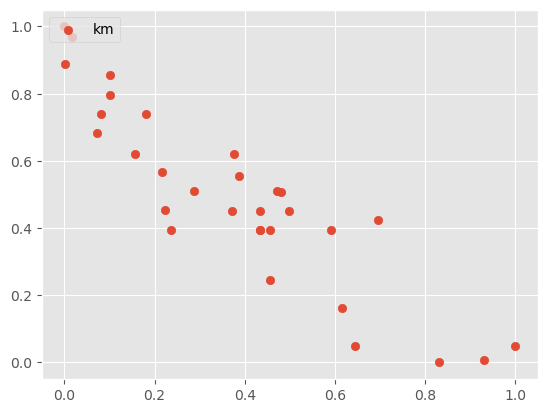

In [221]:
x1 = scaled_df[['km']]
y = scaled_df[['price']]
plt.scatter(x1,y, label='km')
plt.legend(loc='upper left')

Then we will show that there is a linear functionality between price and the km a car has driven

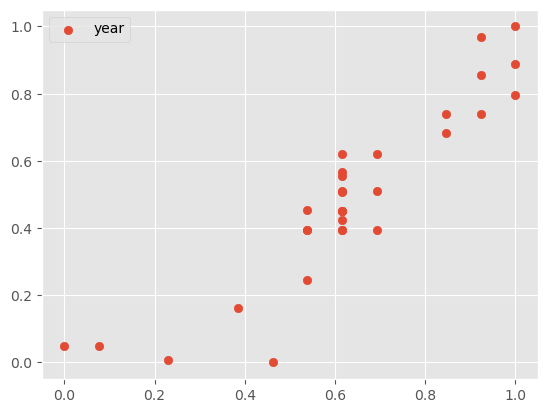

In [220]:
x2 = scaled_df[['year']]
plt.scatter(x2,y, label='year')
plt.legend(loc='upper left')

Based on the findings we decided to do linear regression on the combined values. 
This gave us the coefficient and the interception point which we can plot into a basic linear function.

**f(x) = a + bx**

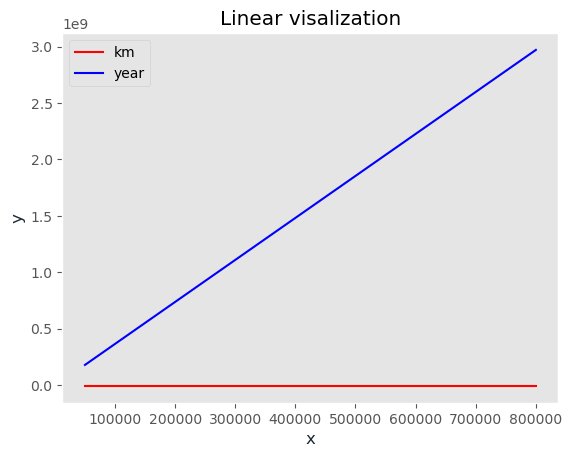

In [223]:
x = np.linspace(50000,800000,100)

km_coeff = int(coeff_df.iloc[0])

year_coeff = int(coeff_df.iloc[1])
y = km_coeff*x+intercept
y1 = year_coeff*x+intercept


plt.plot(x, y, '-r', label='km')
plt.plot(x,y1, '-b', label="year")
plt.title('Linear visalization')
plt.xlabel('x', color='#1C2833')
plt.ylabel('y', color='#1C2833')
plt.legend(loc='upper left')
plt.grid()
plt.show()

### Prediction of results vs real data

In [117]:
# Predicting the results  
y_pred = regressor.predict(X_test) 

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
11,684000,455186.436400
22,420000,403932.078677
10,365000,409568.106817
2,589900,651219.720615
16,419000,451429.084307
14,859000,714685.472640
28,363455,654977.072708


### Prediction of price of the car entered on nummerplade.net

In [97]:
# Predicting result based on car values 
predicted_car_value = regressor.predict([[int(search_car_km),int(search_car_year)]]) 
print("Predicted price of the entered car: ", predicted_car_value)

Predicted price of the entered car:  [387963.33228175]


### Data accuracy

In [67]:
# Data analysis of what and how accurate the data was 

# Vi skal kunne forklare de her tal, de er gode. Men øøøh :) 
# Se bunden af artiklen: https://stackabuse.com/linear-regression-in-python-with-scikit-learn/

from sklearn import metrics
print("Model accuracy: ", regressor.score(X, y))


Model accuracy:  0.641846165936584
